In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control

from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def rot_x(theta):
    rot_x = sp.Matrix([[1,0,0],
                       [0,sp.cos(theta),-sp.sin(theta)],
                       [0,sp.sin(theta),sp.cos(theta)]])
    return rot_x

def rot_y(theta):
    rot_y = sp.Matrix([[sp.cos(theta),0,sp.sin(theta)],
                       [0,1,0],
                       [-sp.sin(theta),0,sp.cos(theta)]])
    return rot_y

def rot_z(theta):
    rot_z = sp.Matrix([[sp.cos(theta),-sp.sin(theta),0],
                       [sp.sin(theta),sp.cos(theta),0],
                       [0,0,1]])
    return rot_z

def trans(a,b,c):
    x = sp.Matrix([[a],[b],[c]])
    return x

def get_torque_from_L(L,q,qd):
    round_L_round_q = sp.zeros(len(q),1);
    i = 0;
    for q_i in q:
        round_L_round_q_i = [];
        round_L_round_q_i = sp.diff(L,q_i);
        round_L_round_q[i] = round_L_round_q_i;
        i+=1;
     
    d_dt_round_L_round_qd = sp.zeros(len(qd),1);
    i = 0;
    for qd_i in qd:
        round_L_round_qd_i = [];
        d_dt_round_L_round_qd_i = [];
        round_L_round_qd_i = sp.diff(L,qd_i);
        d_dt_round_L_round_qd_i = time_derivative(round_L_round_qd_i,N);
        d_dt_round_L_round_qd[i] = d_dt_round_L_round_qd_i;
        i+=1;
        
    tau = d_dt_round_L_round_qd - round_L_round_q 
    return tau

In [3]:
r, L_1, L_b = sp.symbols('r, L_1, L_b')
L_1c = sp.symbols('L_1c')
m_w, m_1, m_b, g = sp.symbols('m_w, m_1, m_b, g')
I_w, I_1, I_b = sp.symbols('I_w, I_1, I_b')
theta_w, theta_1, theta_2 = dynamicsymbols('theta_w, theta_1, theta_2')

# Displacement Vector
x_c = trans(r*theta_w,0,0)
x_w = x_c +  trans(0,0,r)
x_1 = x_w +  rot_y(theta_1) @ trans(0,0,L_1c)
x_b = x_w +  rot_y(theta_1) @ trans(0,0,L_1)+  rot_y(theta_2) @ trans(0,0,L_b)
# x_3 = x_w +  rot_y(theta_1) @ trans(0,0,L_1) + rot_y(theta_2) @ trans(0,0,L_2) + rot_y(theta_3) @ trans(0,0,L_3c) 
# x_4 = x_w +  rot_y(theta_1) @ trans(0,0,L_1) + rot_y(theta_2) @ trans(0,0,L_2) + rot_y(theta_3) @ trans(0,0,L_3) + rot_y(theta_4) @ trans(0,0,L_4c)



# Velocity Vector
v_w = sp.simplify(time_derivative(x_w,N))
v_1 = sp.simplify(time_derivative(x_1,N))
v_b = sp.simplify(time_derivative(x_b,N))



# Angular Velocity Vector
w_w = trans(0, theta_w.diff(), 0)
w_1 = trans(0, theta_1.diff(), 0)
w_b = trans(0, theta_2.diff(), 0)


# Generalized Coordinates
q = sp.Matrix([[theta_w], [theta_1], [theta_2]])
# q = sp.Matrix([[theta_w], [theta_1], [theta_2], [theta_3], [theta_4]])

qd = q.diff()
qdd = qd.diff()

# Kinetic Energy
T_trans = 0.5*(m_w*v_w.dot(v_w)  + m_1*v_1.dot(v_1) + m_b*v_b.dot(v_b) )
# T_trans = 0.5*(m_w*v_w.dot(v_w)  + m_1*v_1.dot(v_1) + m_2*v_2.dot(v_2) + m_3*v_3.dot(v_3) + m_4*v_4.dot(v_4))

T_wheel =I_w* w_w[1]**2 
T_1 =I_1* w_1[1]**2 
T_b =I_b* w_b[1]**2 
# T_4 = I_4* w_4[1]**2 
# T_rot = 0.5*(T_wheel + T_1 + T_2 + T_3 + T_4)
T_rot = 0.5*(T_wheel + T_1 +T_b)


# Potential Energy
V =  m_1*g*(L_1c*sp.cos(theta_1)) + m_b*g*(L_1*sp.cos(theta_1)+L_b*sp.cos(theta_2))
    # + m_3*g*(L_1*sp.cos(theta_1)+L_2*sp.cos(theta_2)+L_3c*sp.cos(theta_3)) \
    # + m_4*g*(L_1*sp.cos(theta_1)+L_2*sp.cos(theta_2)+L_3*sp.cos(theta_3)+L_4c*sp.cos(theta_4))    

# Lagrangian
L = T_trans + T_rot - V


In [4]:
m_w*v_w.dot(v_w)+T_wheel

I_w*Derivative(theta_w(t), t)**2 + m_w*r**2*Derivative(theta_w(t), t)**2

In [5]:
m_1*v_1.dot(v_1)+T_1

I_1*Derivative(theta_1(t), t)**2 + m_1*(L_1c**2*sin(theta_1(t))**2*Derivative(theta_1(t), t)**2 + (L_1c*cos(theta_1(t))*Derivative(theta_1(t), t) + r*Derivative(theta_w(t), t))**2)

In [6]:
m_b*v_b.dot(v_b)+T_b

I_b*Derivative(theta_2(t), t)**2 + m_b*((-L_1*sin(theta_1(t))*Derivative(theta_1(t), t) - L_b*sin(theta_2(t))*Derivative(theta_2(t), t))**2 + (L_1*cos(theta_1(t))*Derivative(theta_1(t), t) + L_b*cos(theta_2(t))*Derivative(theta_2(t), t) + r*Derivative(theta_w(t), t))**2)

In [7]:
tau = get_torque_from_L(L,q,qd)
# tau = sp.simplify(tau)
# Ml, Cl, Gl, Wl = ir.get_EoM_from_T(tau,qdd,g)
# Ml, Cl, Gl, Wl

In [8]:
T_w, T_b= sp.symbols('T_w,T_b')
u = sp.Matrix([[T_w],[T_b]])
# u = sp.Matrix([[T_w], [a], [T_2], [T_3], [T_4]])

u_matrix = sp.Matrix([[-T_w],[T_w+T_b],[-T_b]])
# u_matrix = sp.Matrix([[T_w],[a], [T_2], [T_3], [T_4]])

In [9]:
tau_eq = tau+u_matrix

In [10]:
M, C, G, W = get_EoM_from_T(tau_eq,qdd,g, u)
M

Matrix([
[1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2,   1.0*r*(L_1*m_b + L_1c*m_1)*cos(theta_1(t)),                1.0*L_b*m_b*r*cos(theta_2(t))],
[          1.0*r*(L_1*m_b + L_1c*m_1)*cos(theta_1(t)),           1.0*I_1 + L_1**2*m_b + L_1c**2*m_1, 1.0*L_1*L_b*m_b*cos(theta_1(t) - theta_2(t))],
[                       1.0*L_b*m_b*r*cos(theta_2(t)), 1.0*L_1*L_b*m_b*cos(theta_1(t) - theta_2(t)),                         1.0*I_b + L_b**2*m_b]])

In [11]:
C

Matrix([
[-1.0*r*(L_1*m_b*sin(theta_1(t))*Derivative(theta_1(t), t)**2 + L_1c*m_1*sin(theta_1(t))*Derivative(theta_1(t), t)**2 + L_b*m_b*sin(theta_2(t))*Derivative(theta_2(t), t)**2)],
[                                                                                                       L_1*L_b*m_b*sin(theta_1(t) - theta_2(t))*Derivative(theta_2(t), t)**2],
[                                                                                                      -L_1*L_b*m_b*sin(theta_1(t) - theta_2(t))*Derivative(theta_1(t), t)**2]])

In [12]:
linearlize_eq = {sp.sin(theta_1-theta_2):theta_1-theta_2, sp.cos(theta_1-theta_2):1,sp.sin(theta_2):theta_2, sp.cos(theta_2):1,sp.sin(theta_1):theta_1, sp.cos(theta_1):1, theta_1.diff()**2:0, theta_2.diff()**2:0}
Ml = M.subs(linearlize_eq)
Cl = C.subs(linearlize_eq)
Gl = G.subs(linearlize_eq)
Wl = W.subs(linearlize_eq)
Ml

Matrix([
[1.0*I_w + 1.0*m_1*r**2 + 1.0*m_b*r**2 + 1.0*m_w*r**2,         1.0*r*(L_1*m_b + L_1c*m_1),        1.0*L_b*m_b*r],
[                          1.0*r*(L_1*m_b + L_1c*m_1), 1.0*I_1 + L_1**2*m_b + L_1c**2*m_1,      1.0*L_1*L_b*m_b],
[                                       1.0*L_b*m_b*r,                    1.0*L_1*L_b*m_b, 1.0*I_b + L_b**2*m_b]])

In [13]:
Cl

Matrix([
[0],
[0],
[0]])

In [14]:
Gl

Matrix([
[                                 0],
[-g*(L_1*m_b + L_1c*m_1)*theta_1(t)],
[             -L_b*g*m_b*theta_2(t)]])

In [15]:
W

Matrix([
[ 1,  0],
[-1, -1],
[ 0,  1]])

In [16]:
param = {L_b : 0.500417013226504,I_b :0.572443057472749,m_b: 19.245,I_1: 0.00614941, I_w:0.004806909,  m_1:2.786,   m_w:2.292, r:0.069,L_1c:0.171, L_1: 0.171,  g:9.81}
# m_t: 19.245
Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)

Mlp_inv = Mlp.inv()
qdd_rhs_A = Mlp_inv*(-Clp -Glp)
qdd_rhs_B = Mlp_inv*Wlp*u

X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u

A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)
A
ss0 = [A, B, C, D]
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

A = [[   0.            0.            0.            1.            0.
         0.        ]
     [   0.            0.            0.            0.            1.
         0.        ]
     [   0.            0.            0.            0.            0.
         1.        ]
     [   0.         -856.80315448  -29.13267444    0.            0.
         0.        ]
     [   0.          582.09299048 -184.55345608    0.            0.
         0.        ]
     [   0.          -72.19423545   77.48185211    0.            0.
         0.        ]]

B = [[  0.           0.        ]
     [  0.           0.        ]
     [  0.           0.        ]
     [ 83.14078137  22.8752832 ]
     [-38.93409828 -17.70390674]
     [  1.64509166   2.77358082]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0.]
     [0. 0. 0. 0. 1. 0.]
     [0. 0. 0. 0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]



In [16]:
# Rough 한 조건식
vmax_ = 22/3.6
t_ = 20# sec

target_pos = vmax_*t_
target_pos
v = vmax_/target_pos
a = v/4
a

0.0125

In [17]:
target_pos

122.22222222222221

Vmax : 30.403252247502316 km/r and Amax: 0.15573677653188356 g


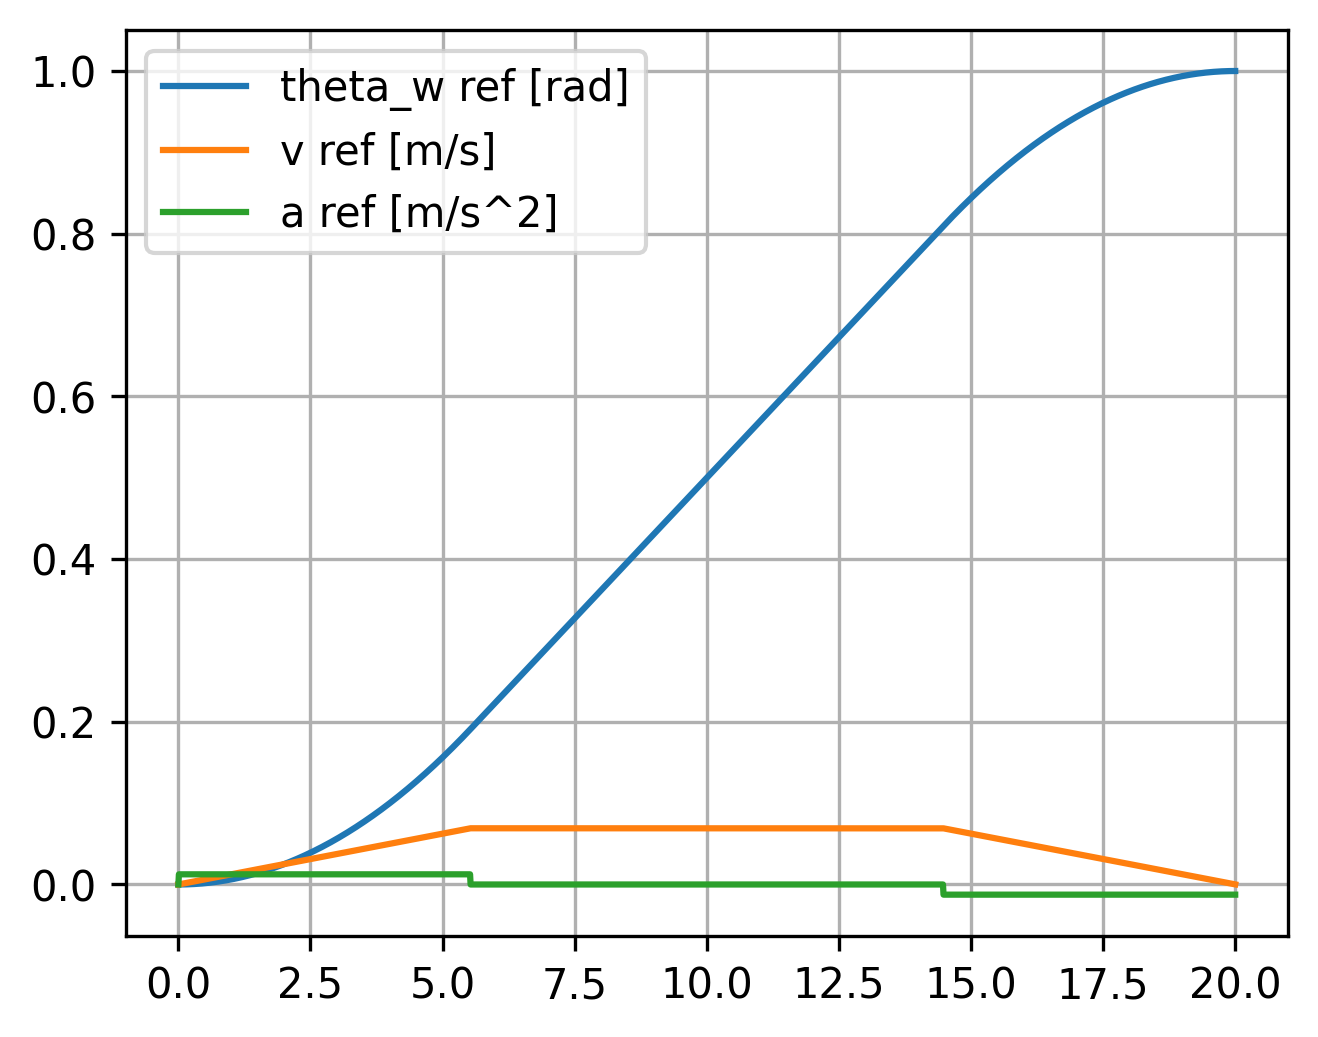

In [18]:
t_s, traj_s = Trapezoidal_Traj_Gen_Given_Amax_and_T(a,t_,0.01)


phi_traj = traj_s/ 0.069

pl.figure(1, figsize=(5,4), dpi=300)
pl.plot(t_s, traj_s)
pl.legend(['theta_w ref [rad]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

print('Vmax :', max(traj_s[:,1])*target_pos*3.6, 'km/r and Amax:', max(traj_s[:,2])*target_pos/9.81, 'g')

In [19]:
q = sp.Matrix([[theta_w], [theta_1], [theta_2]])
theta_w_des = traj_s[:,0]*target_pos
theta_wdot_des = traj_s[:,1]*target_pos
theta_2_des = traj_s[:,2]# using acceleration as xl_des
zeros = np.zeros(len(traj_s))
Xdes = theta_w_des
Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, theta_2_des)) 
Xdes = np.vstack((Xdes, theta_wdot_des))
Xdes = np.vstack((Xdes, zeros))
Xdes = np.vstack((Xdes, zeros))
Xdes.shape, Xdes

((6, 2001),
 array([[ 0.00000000e+00,  7.63888889e-05,  3.05555556e-04, ...,
          1.22221917e+02,  1.22222146e+02,  1.22222146e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.25000000e-02,  1.25000000e-02, ...,
         -1.25000000e-02, -1.25000000e-02, -1.25000000e-02],
        [ 0.00000000e+00,  1.52777778e-02,  3.05555556e-02, ...,
          3.05555556e-02,  1.52777778e-02,  1.52777778e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

In [20]:
Q = sp.Matrix([ [1,0,0,0,0,0],
                [0,1,0,0,0,0],
                [0,0,1,0,0,0],
                [0,0,0,1,0,0],
                [0,0,0,0,1,0],
                [0,0,0,0,0,1] ])
R = sp.Matrix([ [15,0],
                [0,15] ])

K, S, E = control.lqr(A, B, Q, R)

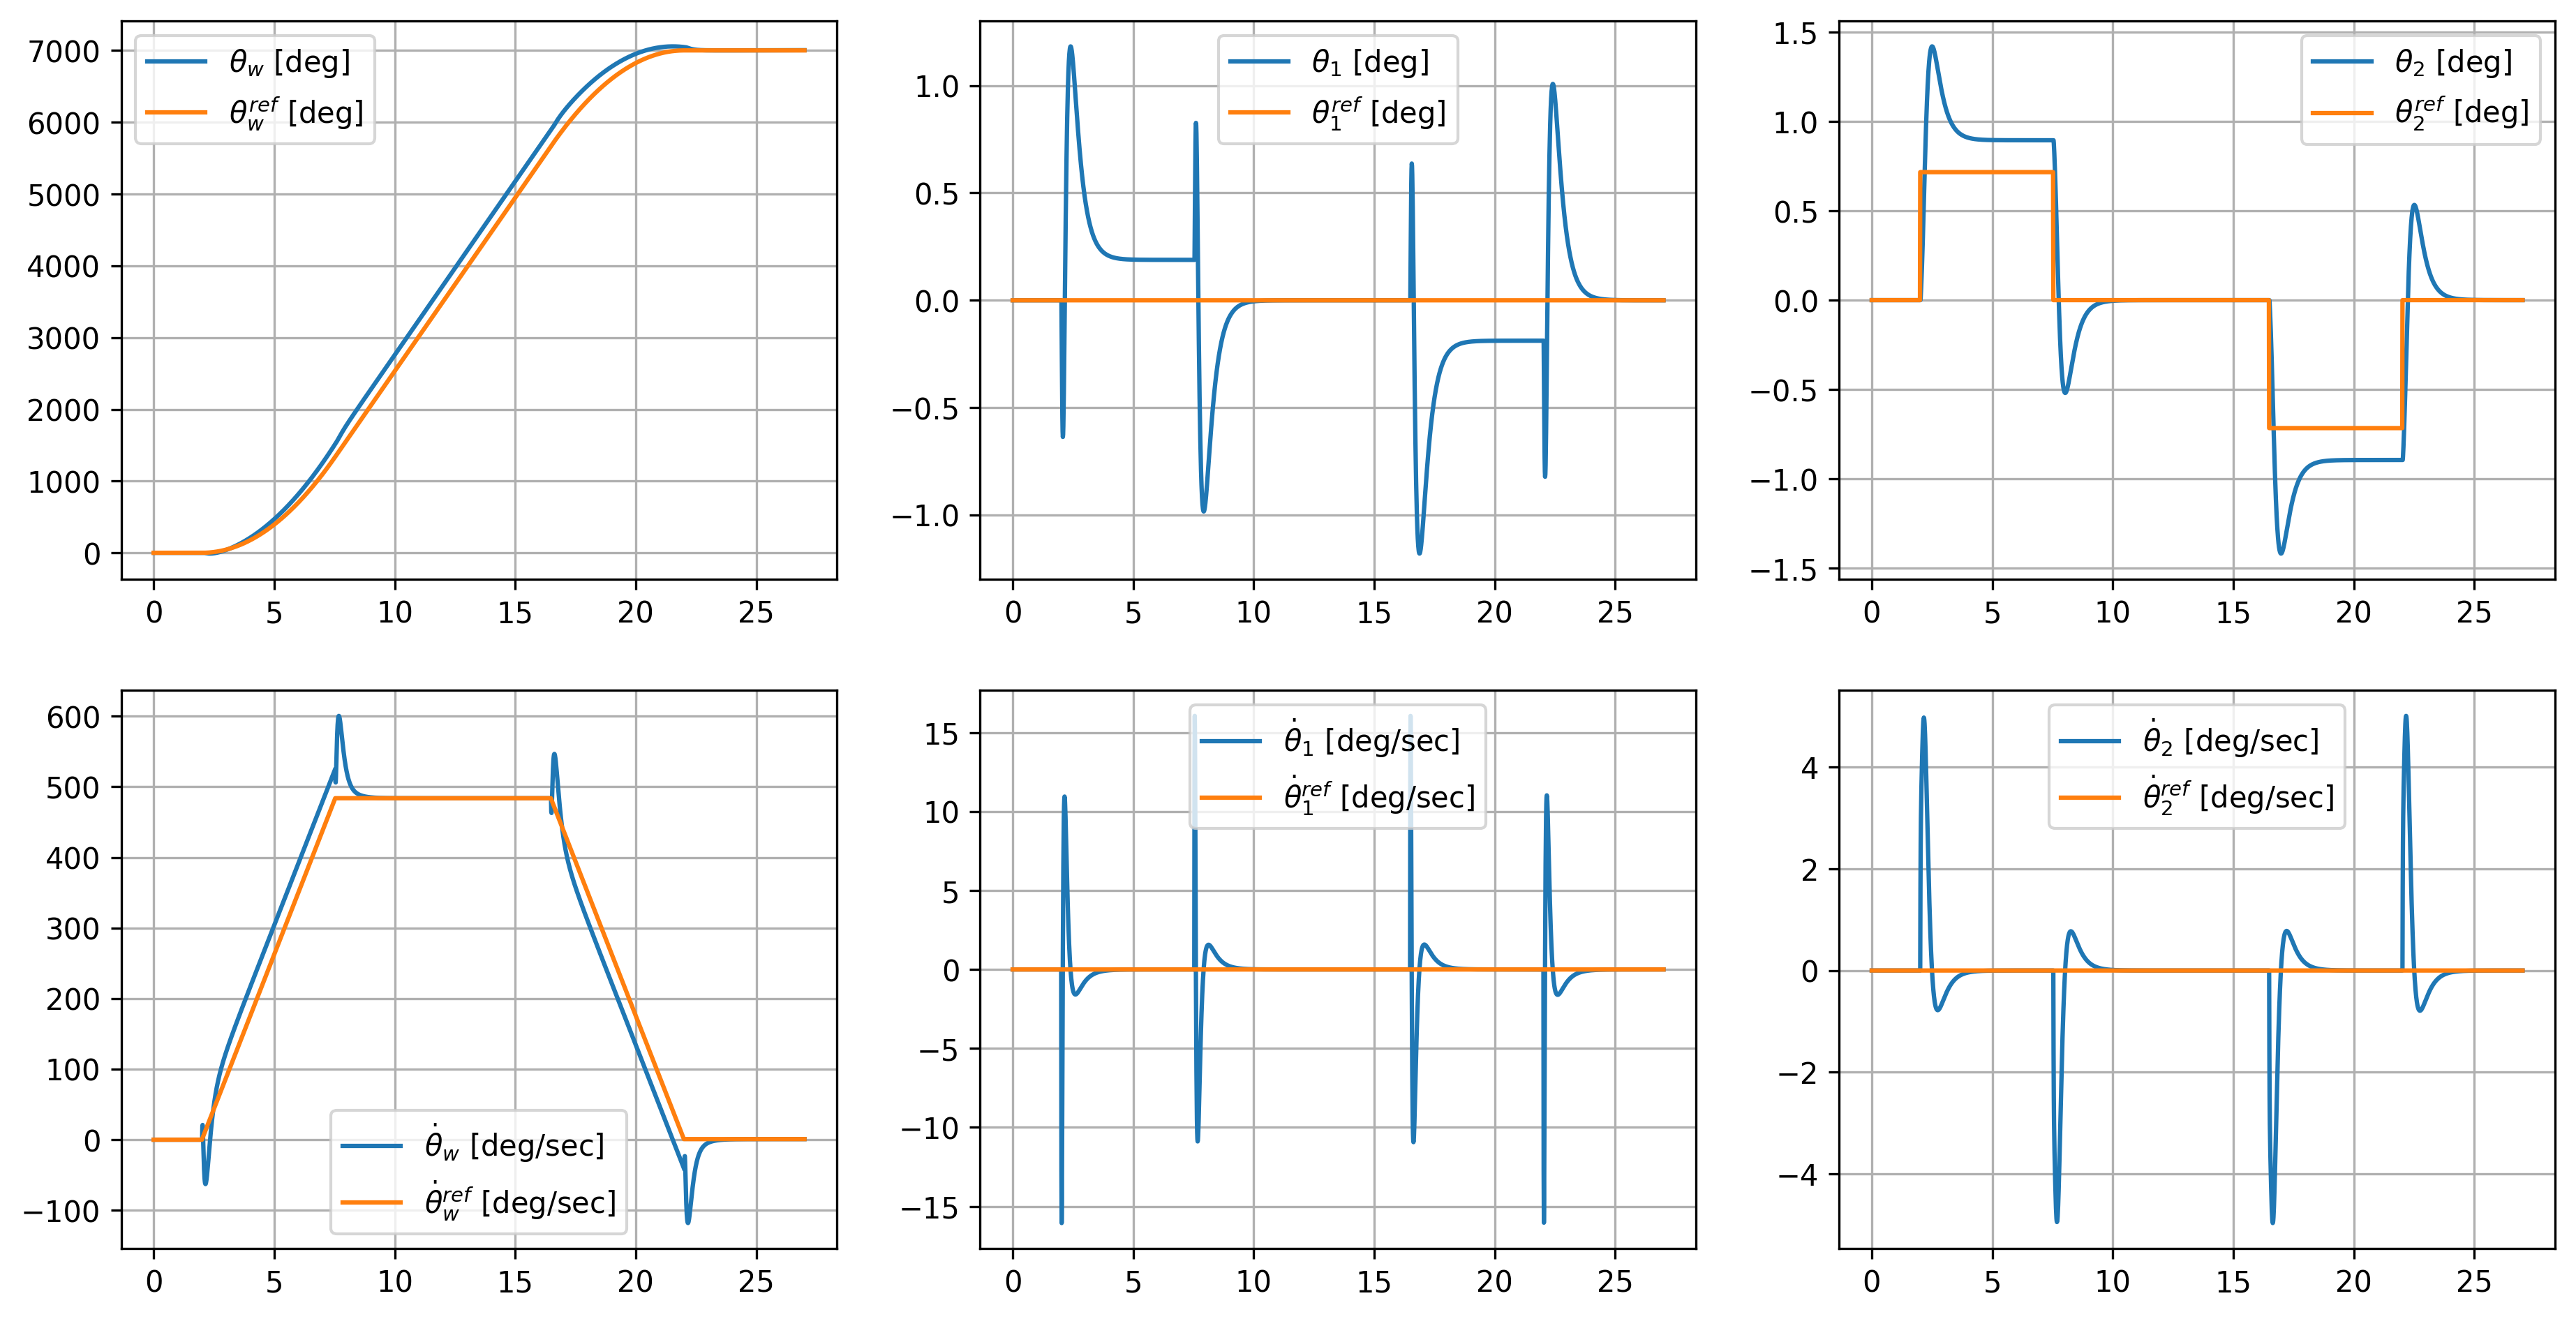

In [21]:
# Closed-loop Simulation
ss = sys0

rad2deg = 180/np.pi

def simulate_model_closed(X0, Xdes, K_gain, time_array, dt):
    Aop = ss.A
    Bop = ss.B
        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0,0,0])
    u_save = np.array([0,0])
    
    for i in range(len(time_array)):
        t = time_array[i]
         
        if t<2:
            Xref = X0       
        elif t>=2 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[2] = 0 # force to set xl_des as 0
            Xref = Xdes_final
        # print(i)

        # partial feedback
        u1 = K_gain[0][1:]@(Xref[1:] - X[1:])
        u2 = K_gain[1][1:]@(Xref[1:] - X[1:])
        
        # Forward Dynamics
        Xd_prev = Xd
        # Linear Model
        u = [u1, u2]
        Xd = Aop@X + Bop@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]
        
        t_save = np.vstack((t_save, t))
        x_save = np.vstack((x_save, X))
        xref_save = np.vstack((xref_save, Xref))
        u_save = np.vstack((u_save, np.array([u1,u2])))
        
        X = X + Xd*dt
        t = t + dt
        i+=1
        
        #limit setting
        # xl_limit = 10
        # if X[2] >= xl_limit:
        #     X[2] = xl_limit
        # elif X[2] <= -xl_limit:
        #     X[2] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [x, x_l, theta, x_dot,x_l_dot, theta_dot]
X0 = np.array([0,0,0,0,0,0])

tf = 20 + 7
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(X0, Xdes, K, t, dt)

pl.figure(1, figsize=(15,12), dpi=300)
pl.subplot(331);
pl.plot(t_sim, x_sim[:,0]*rad2deg, t_sim, xref_sim[:,0]*rad2deg);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,1]*rad2deg, t_sim, xref_sim[:,1]*rad2deg);
pl.legend([r'$\theta_1$ [deg]', r'$\theta_1^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,2]*rad2deg, t_sim, xref_sim[:,2]*rad2deg);
pl.legend([r'$\theta_2$ [deg]', r'$\theta_2^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,3]*rad2deg, t_sim, xref_sim[:,3]*rad2deg);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,4]*rad2deg, t_sim, xref_sim[:,4]*rad2deg);
pl.legend([r'$\dot\theta_1$ [deg/sec]', r'$\dot\theta_1^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,5]*rad2deg, t_sim, xref_sim[:,5]*rad2deg);
pl.legend([r'$\dot\theta_2$ [deg/sec]', r'$\dot\theta_2^{ref}$ [deg/sec]'], loc='best')
pl.grid()

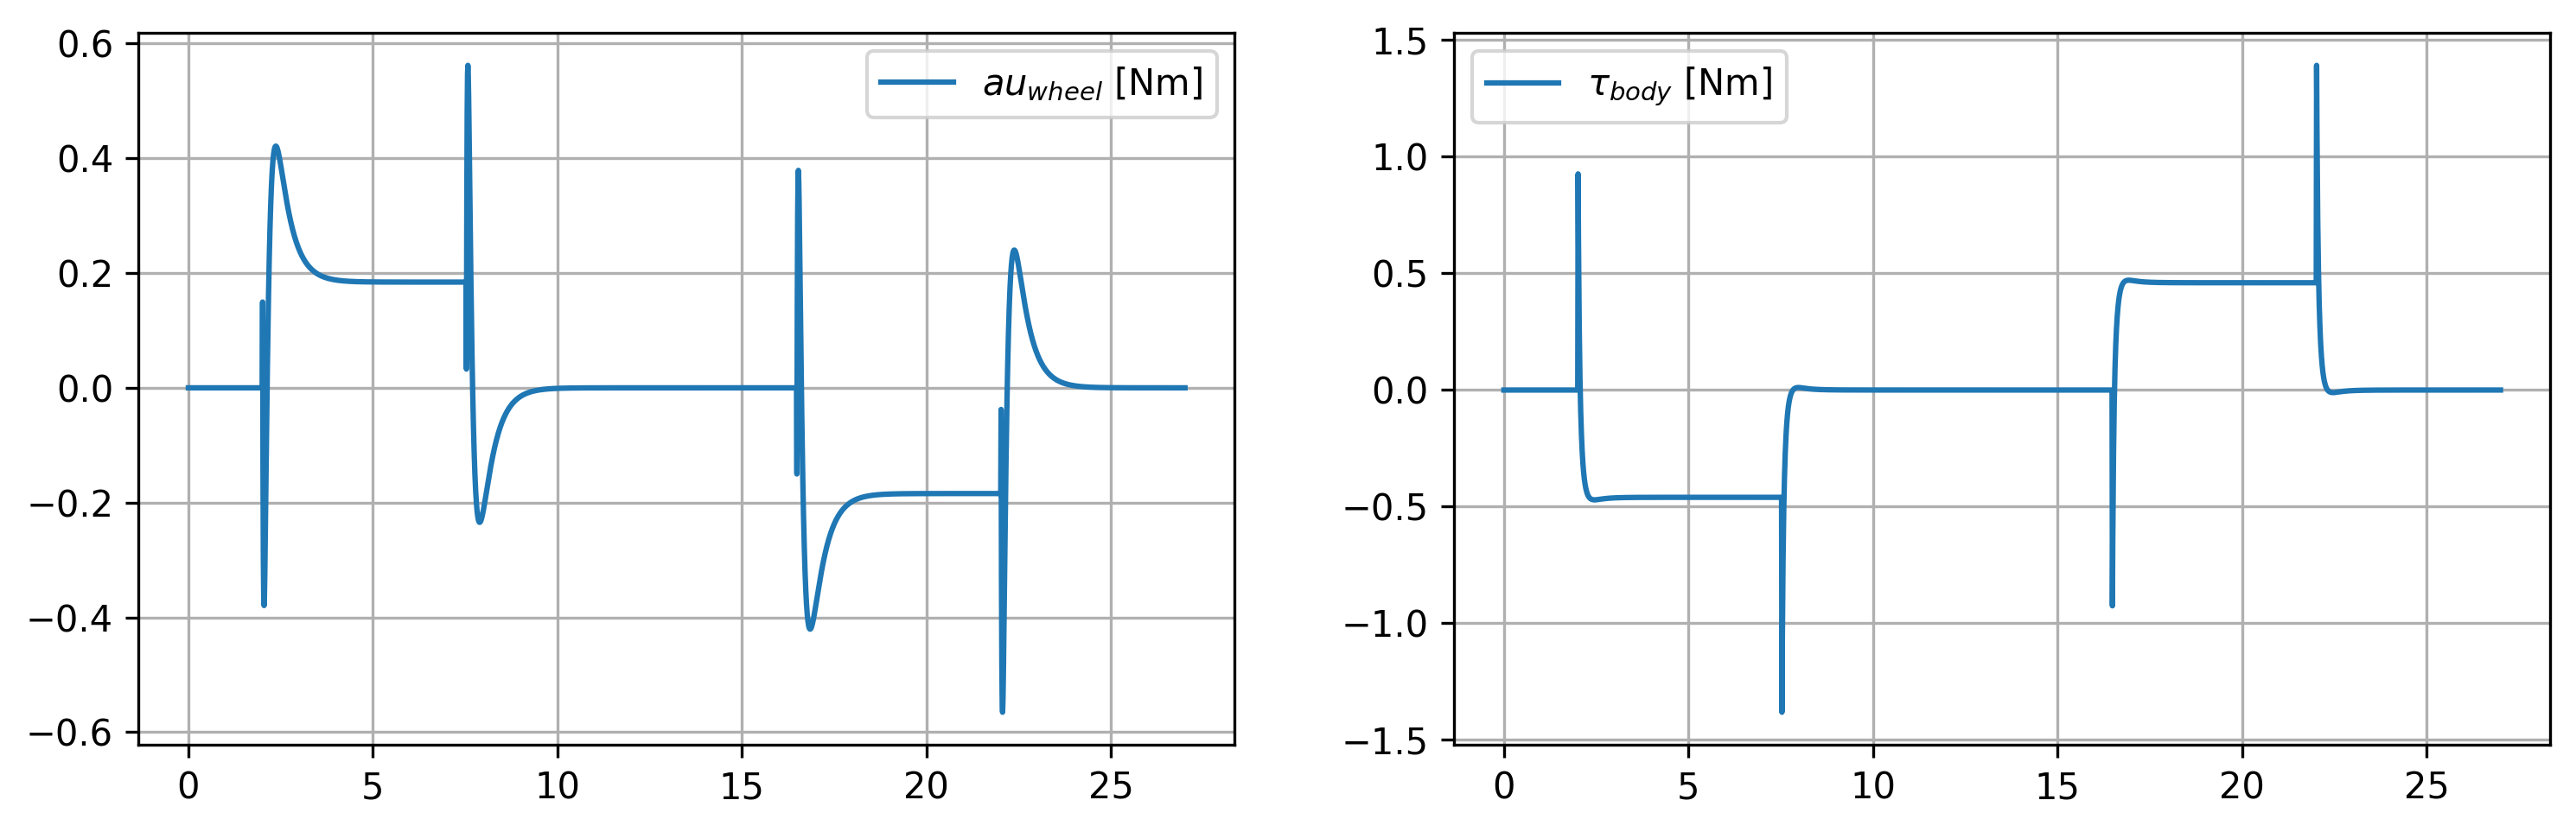

In [22]:
pl.figure(2, figsize=(12,8), dpi=300)
pl.subplot(221);
pl.plot(t_sim, u_sim[:,0]);
pl.legend(['$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

pl.subplot(222);
pl.plot(t_sim, u_sim[:,1]);
pl.legend([r'$\tau_{body}$ [Nm]'], loc='best')
pl.grid()

In [23]:
u_sim

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.00236348e-06, -3.90738380e-08],
       [ 9.75117016e-07, -3.80117244e-08],
       [ 9.48611173e-07, -3.69784814e-08]])